# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [4]:
!pip install transformers[torch]

In [5]:
import pandas as pd
import numpy as np
import torch
import transformers
import torch.nn as nn
from torch.utils.data import DataLoader
import accelerate
from datasets import *
from transformers import AutoTokenizer, BertForSequenceClassification, PreTrainedTokenizerFast, DefaultDataCollator, Trainer, TrainingArguments
from transformers.optimization import AdamW
import random
import matplotlib.pyplot as plt
from transformers.optimization import get_scheduler
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix, classification_report, f1_score,  precision_recall_fscore_support
from sklearn.utils import class_weight
import os
import warnings
warnings.filterwarnings("ignore")
import tqdm.notebook as tq

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

#HYPERPARAMETERS
model_checkpoint = 'prajjwal1/bert-tiny'
#MAX_LEN = 200
NUM_LABELS = 4
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-05
DROPOUT = 0.2
WEIGHT_DECAY = 0.01

Using cpu device


In [7]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    transformers.set_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [8]:
# Load the tokenizer
print(f'Loading tokenizer ...')
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, PreTrainedTokenizerFast)
print('Tokenizer loaded.')

Loading tokenizer ...


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Tokenizer loaded.


In [9]:
#for colab
from google.colab import files
import zipfile


uploaded = files.upload()


zip_filename = next(iter(uploaded))


with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')



Saving files_ass2.zip to files_ass2.zip


In [10]:
#for colab
print(f"Loading data...")
path_labels_data = "./labels_data"
path_arguments_data = "./arguments_data"


def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''

    train_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-training.tsv'), sep='\t')
    test_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-test.tsv'), sep='\t')
    valid_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-validation.tsv'), sep='\t')
    train_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-training.tsv'),sep='\t')
    test_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-test.tsv'),sep='\t')
    valid_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-validation.tsv'),sep='\t')

    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)



(train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels) = load_file()
print("Data loaded.")

Loading data...
Data loaded.


In [11]:
print(f"Loading data...")
def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''
    train_data = pd.read_csv('arguments-training.tsv', sep='\t')
    test_data = pd.read_csv('arguments-test.tsv', sep='\t')
    valid_data = pd.read_csv('arguments-validation.tsv', sep='\t')
    train_labels = pd.read_csv('labels-training.tsv',sep='\t')
    test_labels = pd.read_csv('labels-test.tsv',sep='\t')
    valid_labels = pd.read_csv('labels-validation.tsv',sep='\t')
    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)
(train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels) = load_file()
print("Data loaded.")

Loading data...


FileNotFoundError: [Errno 2] No such file or directory: 'arguments-training.tsv'

In [11]:
# Merge the data and labels
def merge_df(data, labels):
    return pd.merge(data, labels, on='Argument ID')

train_df_merged = merge_df(train_data, train_labels)
val_df_merged = merge_df(valid_data, valid_labels)
test_df_merged = merge_df(test_data, test_labels)

level2_to_level3 = {
    'openness_to_change':["Self-direction: thought", "Self-direction: action","Stimulation", "Hedonism"],
    'self_enhancement':['Hedonism','Achievement', 'Power: dominance', 'Power: resources','Face'],
    'conservation': ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal','Humility'],
    'self_transcendence':['Humility', 'Benevolence: caring', 'Benevolence: dependability','Universalism: concern', 'Universalism: nature','Universalism: tolerance', 'Universalism: objectivity']
}

def lv3_labels(df):
    """
    Function to aggregate specified columns by taking the logical OR between their values.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A new DataFrame with aggregated values.
    """

    # Create a new DataFrame to store aggregated values
    new_df = pd.DataFrame()

    # Iterate over the mapping and compute logical OR for each set of columns
    for new_column, columns_to_aggregate in level2_to_level3.items():
        new_df[new_column] = df[columns_to_aggregate].apply(lambda row: any(row), axis=1).astype(int)  # Convert boolean to int

    # Drop the original columns used for aggregation
    df.drop(columns=[col for cols in level2_to_level3.values() for col in cols], inplace=True)

    # Concatenate new DataFrame with the remaining columns of the original DataFrame
    new_df = pd.concat([df, new_df], axis=1)

    return new_df

df_train = lv3_labels(train_df_merged)
df_val = lv3_labels(val_df_merged)
df_test = lv3_labels(test_df_merged)

In [12]:
def refine_df(df):
    new_df = df.copy()
    new_df["Stance"] = df['Stance'].replace({'in favor of': 1, 'against': 0})
    new_df.drop(df.columns[4:], axis=1, inplace=True)
    new_df['labels'] = df.iloc[:, 4:].apply(lambda x: np.array(list(x)), axis=1)
    return new_df

df_train = refine_df(df_train)
df_test = refine_df(df_test)
df_val = refine_df(df_val)

In [13]:
featurez = ['Conclusion', 'Premise', 'Stance', 'labels']

# Dataframes to Datasets
train_df_to_ds = df_train[featurez]
val_df_to_ds = df_val[featurez]
test_df_to_ds = df_test[featurez]

train_df_to_ds = train_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
val_df_to_ds = val_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
test_df_to_ds = test_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})


In [14]:
tclengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['conclusion']]
tplengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['premise']]

vclengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['conclusion']]
vplengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['premise']]

WC_MAX_LEN = max(tclengths+vclengths)
WCP_MAX_LEN = WC_MAX_LEN + max(tplengths+tplengths) + 1
WCPS_MAX_LEN = WCP_MAX_LEN + 2

print(WC_MAX_LEN)
print(WCP_MAX_LEN)
print(WCPS_MAX_LEN)

38
198
200


In [15]:
#define BertDataset:

class MultilabelDataset(torch.utils.data.Dataset):
    def __init__(self,df:pd.DataFrame, tokenizer:AutoTokenizer, max_len:int):
        self.tokenizer = tokenizer
        self.df = df
        self.conclusion = df.conclusion
        self.premise = df.premise
        self.stance = torch.tensor(df['stance'].values.astype(float), dtype=torch.float)
        self.max_len = max_len
        self.labels = torch.tensor(np.stack(df['labels'].tolist()), dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        conclusion = self.conclusion[index]
        premise = self.premise[index]

        inputs_c = self.tokenizer.encode_plus(
            conclusion,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        inputs_p = self.tokenizer.encode_plus(
            premise,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        ids_c = inputs_c['input_ids'].flatten()
        mask_c = inputs_c['attention_mask'].flatten()
        token_type_ids_c = inputs_c['token_type_ids'].flatten()

        ids_p = inputs_p['input_ids'].flatten()
        mask_p = inputs_p['attention_mask'].flatten()
        token_type_ids_p = inputs_p['token_type_ids'].flatten()

        '''
        return {'ids_c' : torch.tensor(ids_c, dtype=torch.long),
                'mask_c' : torch.tensor(mask_c, dtype=torch.long),
                'token_type_ids_c' : torch.tensor(token_type_ids_c, dtype=torch.long),
                'ids_p':torch.tensor(ids_p, dtype=torch.long),
                'mask_p':torch.tensor(mask_p, dtype=torch.long),
                'token_type_ids_p': torch.tensor(token_type_ids_p, dtype=torch.long),
                'stance' : self.stance[index],
                'labels' : self.labels[index]}
        '''
        return {'ids_c' : ids_c,
                'mask_c' : mask_c,
                'token_type_ids_c' : token_type_ids_c,
                'ids_p':ids_p,
                'mask_p':mask_p,
                'token_type_ids_p': token_type_ids_p,
                'stance' : self.stance[index],
                'labels' : self.labels[index]}

wc_datasets = DatasetDict()
wc_datasets['train'] = MultilabelDataset(train_df_to_ds, tokenizer, WC_MAX_LEN)
wc_datasets['validation'] = MultilabelDataset(val_df_to_ds, tokenizer, WC_MAX_LEN)
wc_datasets['test'] = MultilabelDataset(test_df_to_ds, tokenizer, WC_MAX_LEN)


In [18]:
train_loader = DataLoader(wc_datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(wc_datasets['validation'], batch_size=VALID_BATCH_SIZE, shuffle=False)

In [19]:
# Class Weights
def compute_class_weights_from_df(df):
    # Extracting labels
    labels = df['labels'].tolist()

    # Convert labels to 2D array
    labels_array = np.array([np.array(label) for label in labels])

    # Compute class frequencies
    class_frequencies = np.sum(labels_array, axis=0) / len(labels_array)

    # Compute inverse class frequencies
    inverse_class_frequencies = 1 / class_frequencies

    #print("Inverse Class Frequencies:", inverse_class_frequencies)

    return inverse_class_frequencies

In [20]:

class MultilabelClassifier(nn.Module):
    def __init__(self, num_labels, drop_out=0.1, model_type="base"):
        super(MultilabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.model_type = model_type

        self.bert_conclusion = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=self.num_labels,output_hidden_states=True)

        if model_type != "base":
            self.bert_premise = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=self.num_labels,output_hidden_states=True)

        if model_type == "bert_w_cp":
            self.hidden_dim = self.bert_conclusion.config.hidden_size * 2

        elif model_type == "bert_w_cps":
            self.hidden_dim = (self.bert_conclusion.config.hidden_size * 2) + 1

        else:
            self.hidden_dim = self.bert_conclusion.config.hidden_size


        self.dropout = nn.Dropout(drop_out)
        self.dense = nn.Linear(self.hidden_dim, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # Extracting data for conclusion
        ids_c = inputs['ids_c'].to(device)
        mask_c = inputs['mask_c'].to(device)
        token_type_ids_c = inputs['token_type_ids_c'].to(device)

        # Extracting data for premise
        ids_p = inputs['ids_p'].to(device)
        mask_p = inputs['mask_p'].to(device)
        token_type_ids_p = inputs['token_type_ids_p'].to(device)

        conclusion_outputs = self.bert_conclusion(input_ids=ids_c, attention_mask=mask_c, token_type_ids=token_type_ids_c)
        pooled_output_c = conclusion_outputs.hidden_states[-1][:, 0, :]


        if self.model_type != "base":
            premise_outputs = self.bert_premise(input_ids=ids_p, attention_mask=mask_p, token_type_ids=token_type_ids_p)
            pooled_output_cp = premise_outputs.hidden_states[-1][:, 0, :]

        if self.model_type == "bert_w_cp":
            output = torch.cat((pooled_output_c, pooled_output_cp), dim=1)
        elif self.model_type == "bert_w_cps":
            stance = inputs['stance']
            output = torch.cat((pooled_output_c, pooled_output_cp, stance), dim=1)
        else:
            output = pooled_output_c


        output = self.dropout(output)
        output = self.dense(output)
        output = self.sigmoid(output)
        return output


In [ ]:
'''
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False):
        print("INPUTS",inputs)
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.weighted_loss(logits, labels, self.class_weights)
        return (loss, outputs) if return_outputs else loss

    @staticmethod
    def weighted_loss(logits, labels, class_weights):
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels, weight=class_weights.to(device))
        return loss


    def _prepare_inputs(self, inputs):
        print("INPUTS",inputs)
        print("INPUTS KEYS:",inputs.keys())
        return {
            'input_ids': inputs['ids_c'].to(self.args.device),
            'attention_mask': inputs['mask_c'].to(self.args.device),
            'token_type_ids': inputs['token_type_ids_c'].to(self.args.device),
            'input_ids_p': inputs['ids_p'].to(self.args.device),
            'attention_mask_p': inputs['mask_p'].to(self.args.device),
            'token_type_ids_p': inputs['token_type_ids_p'].to(self.args.device),
            'stance': inputs['stance'].to(self.args.device)
        }

'''

In [25]:
class WeightedLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, predictions, labels):
        loss = nn.BCEWithLogitsLoss(weight=self.class_weights)(predictions, labels)
        return loss


In [30]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

class F1Macro:
    def __init__(self, threshold=0.5, print_per_category=False):
        self.threshold = threshold
        self.print_per_category = print_per_category

    def compute(self, labels, predictions):
        binary_predictions = (predictions > self.threshold).int()
        f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')
        if self.print_per_category:
            per_category_scores = precision_recall_fscore_support(labels, binary_predictions, average=None)
            print("Per-category F1 scores:")
            for i, score in enumerate(per_category_scores[2]):
                print(f"Category {i+1}: {score}")
        return f1_macro

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions.predictions, eval_predictions.label_ids
    f1_macro_computer = F1Macro()
    macro_f1_score = f1_macro_computer.compute(labels, predictions)
    return {"macro_f1": macro_f1_score}

In [21]:
'''
# define f1-score metric
def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions.predictions, eval_predictions.label_ids
    macro_f1_score = compute_f1_macro(labels, predictions)
    return {"macro_f1": macro_f1_score}

def compute_f1_macro(labels, predictions, threshold=0.5, print_per_category=False):
    binary_predictions = (predictions > threshold).int()
    f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')
    if print_per_category:
        per_category_scores = precision_recall_fscore_support(labels, binary_predictions, average=None)
        print("Per-category F1 scores:")
        for i, score in enumerate(per_category_scores[2]):
            print(f"Category {i+1}: {score}")
    return f1_macro
'''

In [38]:
from types import SimpleNamespace

def train_and_validate(epochs, model, train_dataloader, val_dataloader, loss_fn, load_model=False):
    model.train()

    training_args = TrainingArguments(
        output_dir='./Model_Checkpoints',
        overwrite_output_dir=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=VALID_BATCH_SIZE,
        fp16=True if device == 'cuda' else False,
        num_train_epochs=EPOCHS,
        logging_steps=100,
        logging_dir='./logs',
        learning_rate=LEARNING_RATE,
        save_strategy='epoch',
        metric_for_best_model='macro_f1',
        load_best_model_at_end=True,
        save_total_limit=1,
    )

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=len(wc_datasets['train']) // TRAIN_BATCH_SIZE * epochs,
    )

    train_losses = []
    val_losses = []
    f1_scores = []
    val_f1_scores = []


    if not load_model:
        for epoch in range(1, epochs + 1):
            model.train()
            losses = []
            correct_predictions = 0
            num_samples = 0
            f1_scores_epoch = []

            for batch in tqdm(train_dataloader):
                optimizer.zero_grad()
                labels = batch['labels'].float().to(device)

                outputs = model(batch)
                logits = outputs.to(device)
                loss = loss_fn(logits, labels)
                losses.append(loss.item())

                predictions = (torch.sigmoid(logits) > 0.5).int()
                correct_predictions += (predictions == labels).sum().item()
                num_samples += labels.numel()

                f1 = compute_metrics(SimpleNamespace(predictions=predictions.to(device), label_ids=labels))
                f1_scores_epoch.append(f1)

                loss.backward()
                optimizer.step()
                if scheduler:
                    scheduler.step()


            mean_loss = np.mean(losses)
            mean_f1 = np.mean([score["macro_f1"] for score in f1_scores_epoch])

            train_losses.append(mean_loss)
            f1_scores.append(mean_f1)

            #print(f"Epoch {epoch}: Train Loss: {mean_loss:.4f}, Train F1 Score: {mean_f1:.4f}")

            print("Starting the evaluation ...")
            # Validation Step
            model.eval()
            val_losses_epoch = []
            val_f1_scores_epoch = []

            for batch in tqdm(val_dataloader):
                with torch.no_grad():
                    labels = batch['labels'].float().to(device)
                    outputs = model(batch)
                    logits = outputs.to(device)
                    val_loss = loss_fn(logits, labels)
                    val_losses_epoch.append(val_loss.item())

                    predictions = (torch.sigmoid(logits) > 0.5).int()
                    val_f1 = compute_metrics(SimpleNamespace(predictions=predictions.to(device), label_ids=labels))
                    val_f1_scores_epoch.append(val_f1)

            mean_val_loss = np.mean(val_losses_epoch)
            mean_val_f1 = np.mean([score["macro_f1"] for score in val_f1_scores_epoch])

            val_losses.append(mean_val_loss)
            val_f1_scores.append(mean_val_f1)

            print(f"{'Epoch':<6}{'Training Loss':<15}{'Validation Loss':<17}{'Macro F1':<16}{'Val Macro F1':<10}")
            print(f"{epoch:<6}{mean_loss:<15.6f}{mean_val_loss:<17.6f}{mean_f1:<16.6f}{mean_val_f1:<10.6f}")
            #print(f"Epoch {epoch}: Validation Loss: {mean_val_loss:.4f}, Validation F1 Score: {mean_val_f1:.4f}")
            print()

        history = {'model':model, 'train_losses': train_losses,'val_losses': val_losses, 'f1_scores':f1_scores, 'val_f1_scores': val_f1_scores}

    return history


In [36]:
def plot_history(epochs,history, model_type='base'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), history['train_losses'], label='Train Loss')
    plt.plot(range(1, epochs + 1), history['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train Loss vs Validation Loss: {str.upper(model_type)}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), history['f1_scores'], label='Train F1 Score')
    plt.plot(range(1, epochs + 1), history['val_f1_scores'], label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'Train vs Validation F1 Score: {str.upper(model_type)}')
    plt.legend()
    plt.show()


----------------------------------------------------------------------------------------------------
########################### Run with seed: 0 ########################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 0  epochs: 10, batch_size: 64, dropout: 0.2,lr : 1e-05,

MODEL CREATION


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.300319       1.238767         0.722753        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.242974       1.221839         0.722825        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.231044       1.215990         0.722684        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.225456       1.213003         0.723023        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.222684       1.211290         0.721788        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.220822       1.210157         0.722499        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.219706       1.209483         0.722248        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.218838       1.209053         0.722472        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.219078       1.208791         0.722540        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.218078       1.208723         0.722697        0.727134  

Cleaning CPU memory...

Cleaning Done!
############################## Training 0 done. #######################################################


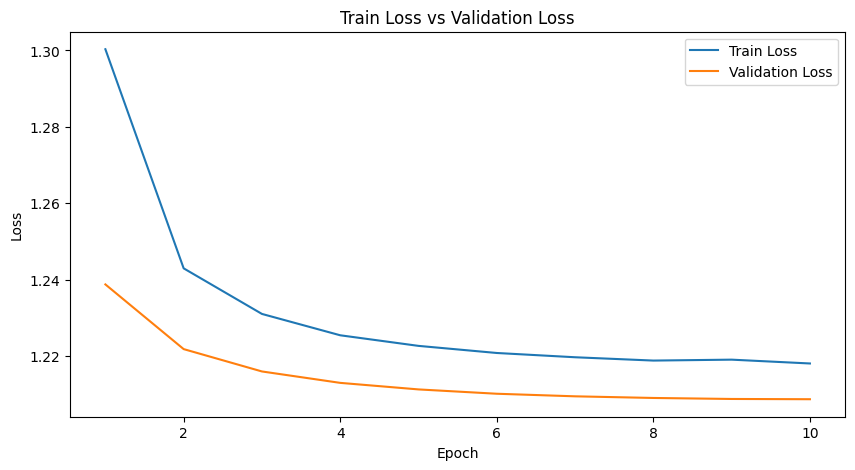

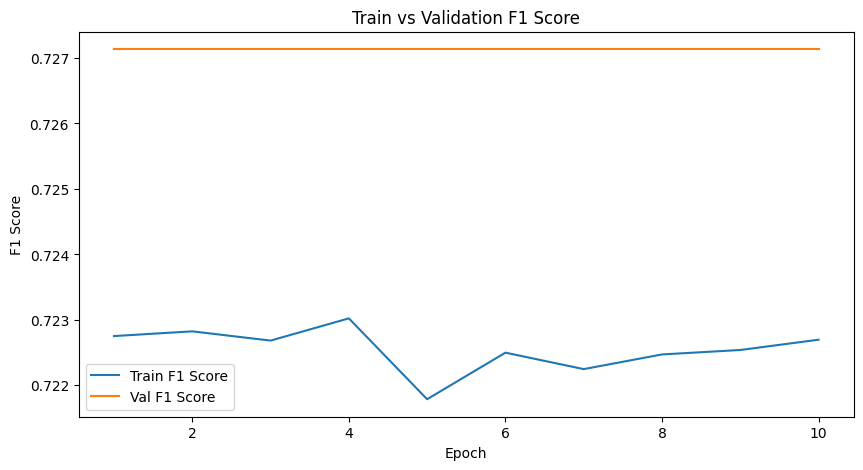

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
########################### Run with seed: 42 ########################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 42  epochs: 10, batch_size: 64, dropout: 0.2,lr : 1e-05,

MODEL CREATION
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.282376       1.248822         0.722614        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.248959       1.231270         0.723018        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.236126       1.223862         0.722335        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.230524       1.219982         0.722152        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.227473       1.217610         0.721910        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.224452       1.216185         0.722844        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.223384       1.215157         0.723032        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.222663       1.214518         0.722584        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.221805       1.214184         0.722766        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.222435       1.214083         0.722249        0.727134  

Cleaning CPU memory...

Cleaning Done!
############################## Training 42 done. #######################################################


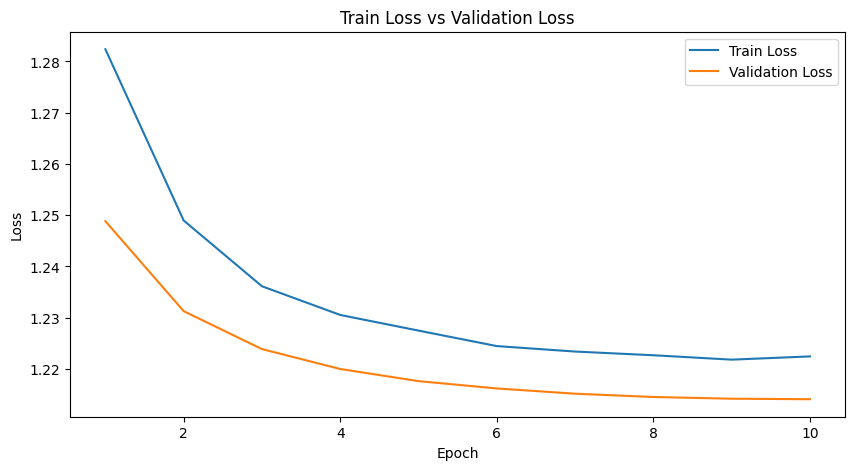

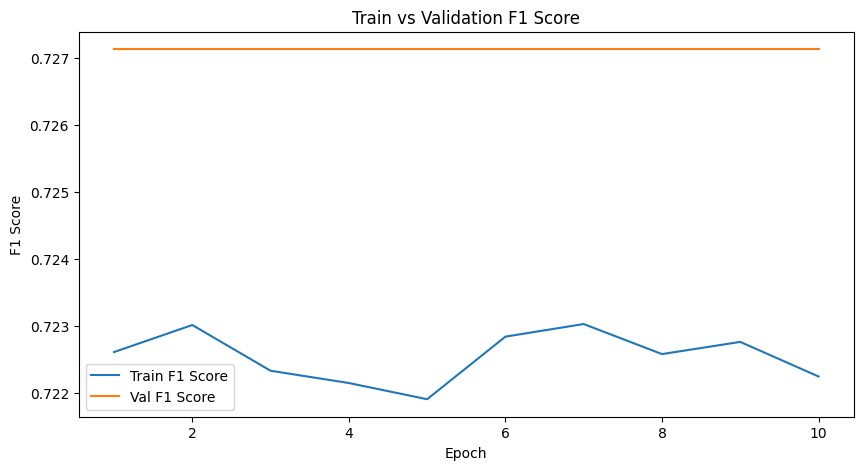

----------------------------------------------------------------------------------------------------
########################### Run with seed: 121 ########################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 121  epochs: 10, batch_size: 64, dropout: 0.2,lr : 1e-05,

MODEL CREATION


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.261564       1.234955         0.722320        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.232120       1.220799         0.722447        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.224796       1.215795         0.722011        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.221982       1.213060         0.722503        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.219968       1.211501         0.722641        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.218391       1.210518         0.722245        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.217660       1.209916         0.722752        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.217411       1.209522         0.722073        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.216637       1.209330         0.722571        0.727134  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.216101       1.209274         0.721848        0.727134  

Cleaning CPU memory...

Cleaning Done!
############################## Training 121 done. #######################################################


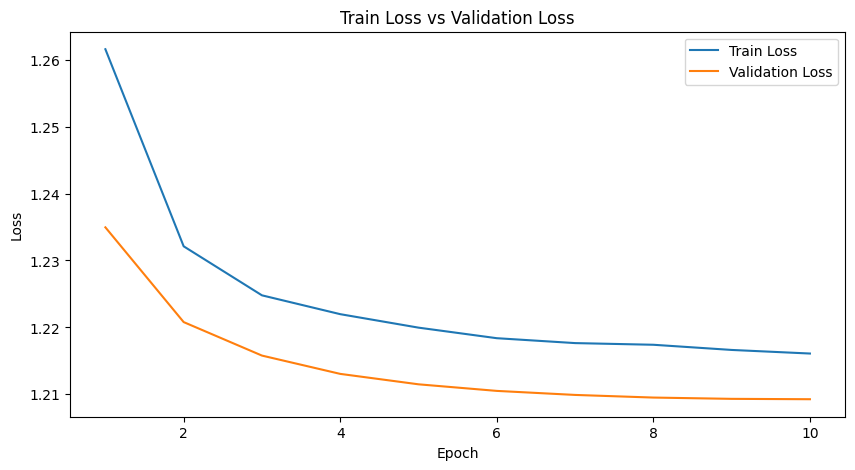

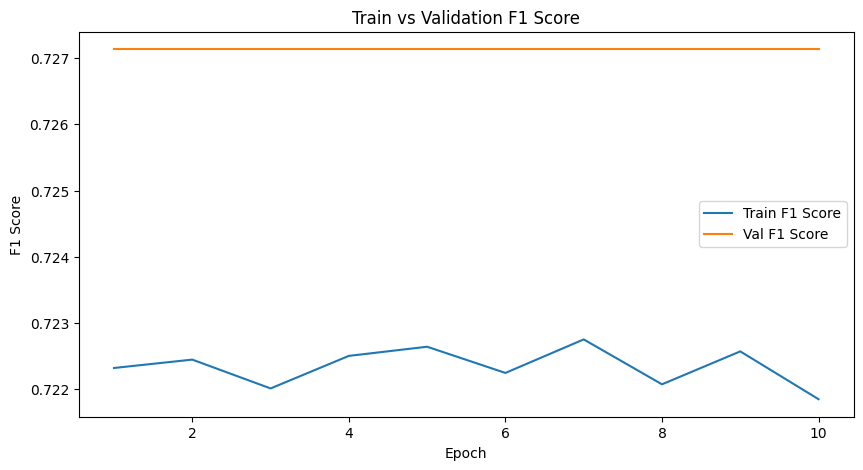

In [39]:
SEED = [0,42,121]

for seed in SEED:
      print("-"*100)
      print(f"########################### Run with seed: {seed} ########################################")

      print(f"Setting seed for reproducibility")
      set_reproducibility(seed)
      print("Done")
      print()

      print("SELECTED HYPERPARAMETERS")
      hyp_str = f"run_num: {seed}  epochs: {EPOCHS}, batch_size: {TRAIN_BATCH_SIZE}, dropout: {DROPOUT},lr : {LEARNING_RATE},"
      print(hyp_str)
      print()

      print("MODEL CREATION")
      model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type="base")
      model.to(device)
      print("Done")
      print()

      loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))

      print("START TRAINING")
      print()
      history = train_and_validate(EPOCHS,model,train_loader,val_loader,loss_fn,load_model=False)



      print(f"Cleaning {str.upper(device)} memory...")
      print()
      del model
      torch.cuda.empty_cache()
      print("Cleaning Done!")


      print(f"############################## Training {seed} done. #######################################################")

      plot_history(EPOCHS,history)


In [ ]:
wcp_datasets = DatasetDict()
wcp_datasets['train'] = MultilabelDataset(train_df_to_ds, tokenizer, WCP_MAX_LEN)
wcp_datasets['validation'] = MultilabelDataset(val_df_to_ds, tokenizer, WCP_MAX_LEN)
wcp_datasets['test'] = MultilabelDataset(test_df_to_ds, tokenizer, WCP_MAX_LEN)

train_loader_cp =  DataLoader(wcp_datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader_cp = DataLoader(wcp_datasets['validation'], batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
SEED = [0,42,121]

for seed in SEED:
      print("-"*100)
      print(f"########################### Run with seed: {seed} ########################################")

      print(f"Setting seed for reproducibility")
      set_reproducibility(seed)
      print("Done")
      print()

      print("SELECTED HYPERPARAMETERS")
      hyp_str = f"run_num: {seed}  epochs: {EPOCHS}, batch_size: {TRAIN_BATCH_SIZE}, dropout: {DROPOUT},lr : {LEARNING_RATE},"
      print(hyp_str)
      print()

      print("MODEL CREATION")
      model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type="berta_w_cp")
      model.to(device)
      print("Done")
      print()

      loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))

      print("START TRAINING")
      print()
      history = train_and_validate(EPOCHS,model,train_loader_cp,val_loader_cp,loss_fn,load_model=False)



      print(f"Cleaning {str.upper(device)} memory...")
      print()
      del model
      torch.cuda.empty_cache()
      print("Cleaning Done!")


      print(f"############################## Training {seed} done. #######################################################")

      plot_history(EPOCHS,history,model_type='cp')


### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End